In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_cv
import os
import re

2024-06-09 12:13:33.664408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 12:13:34.573455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Pipeline

In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# dataset_location = './Food ingredient recognition.v4i.tfrecord'
# dataset_location = './drive/MyDrive/Food ingredient recognition.v4i.tfrecord' # Google Colab
# dataset_location = "/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/Food ingredient recognition.v4i.tfrecord" # Punya Andi (yang lama)
dataset_location = "/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/FOOD-INGREDIENTS dataset.v4i.tfrecord" # Punya Andi (yang baru)   
# tfrecord_name = "food-ingredient.tfrecord" # yang lama
tfrecord_name = "FOOD-INGREDIENTS.tfrecord" # Yang baru
# label_map_name = "food-ingredient_label_map.pbtxt" # yang lama
label_map_name = "FOOD-INGREDIENTS_label_map.pbtxt" # yang baru
print(os.path.exists(dataset_location))

True


In [3]:
dataset_train = tf.data.TFRecordDataset(dataset_location + f"/train/{tfrecord_name}")
dataset_validation = tf.data.TFRecordDataset(dataset_location + f"/valid/{tfrecord_name}")
dataset_test = tf.data.TFRecordDataset(dataset_location + f"/test/{tfrecord_name}")

2024-06-09 12:13:42.261488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 12:13:42.371621: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 12:13:42.371741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 12:13:42.375025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 12:13:42.375130: I external/local_xla/xla/stream_executor

In [4]:
feature_description = {
    'image/object/bbox/ymin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax' : tf.io.VarLenFeature(tf.float32),
    'image/object/class/text' : tf.io.VarLenFeature(tf.string),
    'image/object/class/label' : tf.io.VarLenFeature(tf.int64),
    'image/encoded' : tf.io.FixedLenFeature([], tf.string),
    'image/format' : tf.io.FixedLenFeature([], tf.string),
    'image/filename' : tf.io.FixedLenFeature([], tf.string),
    'image/height' : tf.io.FixedLenFeature([], tf.int64),
    'image/width' : tf.io.FixedLenFeature([], tf.int64)
}
def _parse_function(example_proto):
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    bounding_box = ['image/object/bbox/ymin', 'image/object/bbox/xmin', 'image/object/bbox/ymax', 'image/object/bbox/xmax']
    for key in ['image/object/bbox/ymin', 'image/object/bbox/xmin', 'image/object/bbox/ymax', 'image/object/bbox/xmax', 'image/object/class/text', 'image/object/class/label']:
        parsed_example[key] = tf.sparse.to_dense(parsed_example[key])
        if (key in bounding_box and "x" in key):
            parsed_example[key] = parsed_example[key] * tf.cast(parsed_example['image/width'], tf.float32)
        elif (key in bounding_box):
            parsed_example[key] = parsed_example[key] * tf.cast(parsed_example['image/height'], tf.float32)
    return parsed_example

In [5]:
def parse_pbtxt(pbtxt_content):
    # Regular expressions for extracting id, name, and display_name
    id_pattern = re.compile(r'id:\s*(\d+)')
    name_pattern = re.compile(r'name:\s*"([^"]+)"')
    display_name_pattern = re.compile(r'display_name:\s*"([^"]+)"')

    label_map = []

    items = pbtxt_content.split('item {')
    for item in items:
        if not item.strip():
            continue
        
        id_match = id_pattern.search(item)
        name_match = name_pattern.search(item)
        display_name_match = display_name_pattern.search(item)
        
        if id_match and name_match:
            item_dict = {
                'id': int(id_match.group(1)),
                'name': name_match.group(1),
                'display_name': display_name_match.group(1) if display_name_match else name_match.group(1)
            }
            label_map.append(item_dict)

    return label_map

def parse_pbtxt_file(file_path):
    with open(file_path, 'r') as file:
        pbtxt_content = file.read()
    return parse_pbtxt(pbtxt_content)


In [6]:
from keras_cv import bounding_box
from keras_cv import visualization

label_map = parse_pbtxt_file(dataset_location + f"/train/{label_map_name}")

class_mapping = {item['id']: item['display_name'] for item in label_map}

def preprocess_dataset(parsed_dataset):
    image = tf.image.decode_jpeg(parsed_dataset['image/encoded'])
    label = parsed_dataset['image/object/class/label']
    bounding_box = tf.stack([
        parsed_dataset['image/object/bbox/xmin'],
        parsed_dataset['image/object/bbox/ymin'],
        parsed_dataset['image/object/bbox/xmax'],
        parsed_dataset['image/object/bbox/ymax']
    ], axis=-1)
    image = tf.cast(image, tf.float32)
    return {
        'images': image,
        'bounding_boxes' : {
            'boxes': tf.cast(bounding_box, tf.float32),
            'classes': tf.cast(label, tf.int32)
        }
    }

def visualize_data(image, bounding_boxes):
    image = np.array(image)
    inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
    )
    image = inference_resizing([image])
    visualization.plot_bounding_box_gallery(
        image,
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xywh',
        y_pred=bounding_boxes
    )

augmenter = tf.keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            # target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
            target_size=(640, 640), scale_factor=(1, 1), bounding_box_format="xyxy"
        ),
    ]
)

validation_augmenter = tf.keras.Sequential(
    layers=[
        keras_cv.layers.JitteredResize(
            # target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
            target_size=(640, 640), scale_factor=(1, 1), bounding_box_format="xyxy"
        )
    ]
)

2024-06-09 12:14:03.595008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


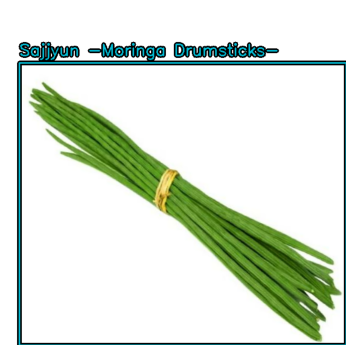

In [7]:
from keras_cv import bounding_box

BATCH_SIZE = 16

train_data_initial = dataset_train.map(_parse_function).map(preprocess_dataset).shuffle(buffer_size=BATCH_SIZE * 4).ragged_batch(BATCH_SIZE, drop_remainder=True)
train_data_resized = train_data_initial.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(inputs["bounding_boxes"], max_boxes=32)

train_data = train_data_resized.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

for result in train_data.take(1):
    visualization.plot_bounding_box_gallery(
        result[0],
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xyxy',
        y_true=result[1],
        class_mapping=class_mapping
    )


In [20]:
validation_data_initial = dataset_validation.map(_parse_function).map(preprocess_dataset).shuffle(buffer_size=BATCH_SIZE * 4).ragged_batch(BATCH_SIZE, drop_remainder=True)
validation_data_resized = validation_data_initial.map(validation_augmenter, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data_resized.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

In [21]:
test_data_initial = dataset_test.map(_parse_function).map(preprocess_dataset).shuffle(buffer_size=BATCH_SIZE * 4).ragged_batch(BATCH_SIZE, drop_remainder=True)
test_data_resized = test_data_initial.map(validation_augmenter, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data_resized.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [22]:
# import keras

# pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
#     "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
# )
# image = keras.utils.load_img("stock-photo-airport-with-many-airplanes-at-beautiful-sunset-324754607.jpg")
# image = np.array(image)
# # print(image.shape)

# visualization.plot_image_gallery(
#     np.array([image]),
#     value_range=(0, 255),
#     rows=1,
#     cols=1,
#     scale=5,)
# inference_resizing = keras_cv.layers.Resizing(
#     640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
# )
# image_batch = inference_resizing([image])
# # print(image_batch)
# class_ids = [
#     "Aeroplane",
#     "Bicycle",
#     "Bird",
#     "Boat",
#     "Bottle",
#     "Bus",
#     "Car",
#     "Cat",
#     "Chair",
#     "Cow",
#     "Dining Table",
#     "Dog",
#     "Horse",
#     "Motorbike",
#     "Person",
#     "Potted Plant",
#     "Sheep",
#     "Sofa",
#     "Train",
#     "Tvmonitor",
#     "Total",
# ]
# # class_mapping = dict(zip(range(len(class_ids)), class_ids))
# # y_pred = pretrained_model.predict(image_batch)

# # print(y_pred)

# for sample in train_data_unbatched.take(1):
#     image = np.array(sample['images'])
#     inference_resizing = keras_cv.layers.Resizing(
#     640, 640, pad_to_aspect_ratio=True, bounding_box_format="xyxy"
#     )
#     image = inference_resizing([image])
#     y_pred = pretrained_model.predict(image)
#     print(y_pred)
#     visualization.plot_bounding_box_gallery(
#         image,
#         value_range=(0, 255),
#         rows=1,
#         cols=1,
#         y_pred=y_pred,
#         scale=5,
#         font_scale=0.7,
#         bounding_box_format="xyxy",
#         class_mapping=class_mapping,
#     )


In [23]:
# Get the number of classes in the dataset
# unique_classes = set()
# for parsed_dataset in train_data:
#     classes = parsed_dataset['bounding_boxes']['classes'].numpy()
#     unique_classes.update(np.unique(classes))

# NUM_CLASSES = len(unique_classes)
NUM_CLASSES = len(class_ids)

In [24]:
# Pretrained backbone
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco",
    include_rescaling = True,
)

prediction_decoder = keras_cv.layers.NonMaxSuppression(
    from_logits=True,
    # Makin tinggi perlu confidence makin tinggi
    confidence_threshold=0.731,
    # Makin rendah maka makin sedikit bounding box yang diambil
    iou_threshold=0.2,
    bounding_box_format="xyxy",
)

model = keras_cv.models.YOLOV8Detector(
    num_classes=NUM_CLASSES,
    bounding_box_format="xyxy",
    backbone=backbone,
    # fpn_depth=1,
    prediction_decoder=prediction_decoder,
)


# model = keras_cv.models.YOLOV8Detector.from_preset(
#     "yolo_v8_s_backbone_coco", 
#     bounding_box_format="xyxy",
#     num_classes=NUM_CLASSES,
#     prediction_decoder=prediction_decoder,
#     include_rescaling = True,
# )



In [25]:
freeze = 133
# Freeze to up to 133 layers
# for i, layer in enumerate(model.layers):
#     if i < freeze:
#         layer.trainable = False


In [26]:
class EvaluateCOCOMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [27]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    global_clipnorm = 10.0
)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

model.compile(
    optimizer=optimizer, 
    # classification_loss="binary_crossentropy", 
    classification_loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    box_loss=keras_cv.losses.CIoULoss("xyxy", eps=1e-07)
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

model.fit(train_data, 
          epochs=350, 
          validation_data=validation_data,
          callbacks=[EvaluateCOCOMetricsCallback(validation_data, "model.keras")])

Epoch 1/350


I0000 00:00:1717905287.069604  734969 service.cc:145] XLA service 0x7f86200020f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717905287.069746  734969 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-09 10:54:50.329674: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-09 10:54:52.383812: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1717905331.104139  734969 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_negate_slice_fusion_1', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1717905331.154087  734969 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    183/Unknown 94s 153ms/step - loss: 7.8475e-05

2024-06-09 10:55:59.369584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 10:55:59.370802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-06-09 10:56:05.232473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 10:56:05.232811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is abortin

183/183 ━━━━━━━━━━━━━━━━━━━━ 109s 234ms/step - loss: 7.8460e-05 - val_loss: 8.1211e-05 - MaP: 5.0515e-06 - MaP@[IoU=50]: 2.5258e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.8579e-06 - Recall@[max_detections=1]: 2.8011e-04 - Recall@[max_detections=10]: 2.8011e-04 - Recall@[max_detections=100]: 2.8011e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 3.8314e-04
Epoch 2/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 7.3337e-05

2024-06-09 10:56:45.631064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 10:56:45.631690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 10:56:47.569556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 10:56:47.570002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 10:56:50.602303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 186ms/step - loss: 7.3330e-05 - val_loss: 7.9461e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 3/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 7.1384e-05

2024-06-09 10:57:22.336115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 10:57:22.336866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 10:57:24.272816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 10:57:24.272916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 36s 183ms/step - loss: 7.1390e-05 - val_loss: 7.7311e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 4/350


2024-06-09 10:57:27.028491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.8035e-05

2024-06-09 10:57:58.620610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 10:57:58.620900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 10:58:00.502363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 10:58:00.502840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 36s 185ms/step - loss: 6.8038e-05 - val_loss: 7.8280e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 5/350


2024-06-09 10:58:03.313538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 6.9741e-05

2024-06-09 10:58:34.311064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 10:58:34.311297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 10:58:36.064617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 10:58:36.064894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 10:58:39.060127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.9737e-05 - val_loss: 8.0422e-05 - MaP: 0.0023 - MaP@[IoU=50]: 0.0071 - MaP@[IoU=75]: 4.4913e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0025 - Recall@[max_detections=1]: 0.0080 - Recall@[max_detections=10]: 0.0080 - Recall@[max_detections=100]: 0.0080 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0085
Epoch 6/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 7.1851e-05

2024-06-09 10:59:11.887573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 10:59:11.888186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 10:59:13.771106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 10:59:13.771314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 10:59:16.661159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 36s 184ms/step - loss: 7.1844e-05 - val_loss: 7.5930e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 7/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.9496e-05

2024-06-09 10:59:48.308003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 10:59:48.308638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 10:59:50.320508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 10:59:50.320719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 10:59:53.390912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 6.9493e-05 - val_loss: 7.9111e-05 - MaP: 0.0027 - MaP@[IoU=50]: 0.0061 - MaP@[IoU=75]: 0.0016 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0029 - Recall@[max_detections=1]: 0.0100 - Recall@[max_detections=10]: 0.0100 - Recall@[max_detections=100]: 0.0100 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0106
Epoch 8/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 6.8418e-05

2024-06-09 11:00:25.593317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:00:25.593905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:00:27.413190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:00:27.413437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 35s 182ms/step - loss: 6.8411e-05 - val_loss: 7.5622e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 9/350


2024-06-09 11:00:30.232929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 6.7025e-05

2024-06-09 11:01:02.280678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:01:02.281347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:01:04.355101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:01:04.355281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:01:07.189060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 186ms/step - loss: 6.7029e-05 - val_loss: 7.1599e-05 - MaP: 1.6323e-06 - MaP@[IoU=50]: 1.6323e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 4.1040e-06 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 3.0303e-04 - Recall@[max_detections=100]: 3.0303e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 7.4074e-04 - Recall@[area=large]: 0.0000e+00
Epoch 10/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.8503e-05

2024-06-09 11:01:38.857487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:01:38.857726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:01:40.756179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:01:40.756509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:01:43.513664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - loss: 6.8502e-05 - val_loss: 7.1370e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 11/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 6.8337e-05

2024-06-09 11:02:15.263755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:02:15.264362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:02:17.191258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:02:17.191481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:02:19.986241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 36s 181ms/step - loss: 6.8333e-05 - val_loss: 7.6128e-05 - MaP: 0.0019 - MaP@[IoU=50]: 0.0055 - MaP@[IoU=75]: 2.3831e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0020 - Recall@[max_detections=1]: 0.0065 - Recall@[max_detections=10]: 0.0065 - Recall@[max_detections=100]: 0.0065 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0069
Epoch 12/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.6140e-05

2024-06-09 11:02:51.860554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:02:51.860857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:02:53.593065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:02:53.593148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:02:56.340516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 36s 185ms/step - loss: 6.6139e-05 - val_loss: 7.3770e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 13/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.7342e-05

2024-06-09 11:03:27.858840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:03:27.859452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:03:29.669789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:03:29.669857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:03:32.638853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 36s 185ms/step - loss: 6.7339e-05 - val_loss: 7.4097e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 14/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.7442e-05

2024-06-09 11:04:04.475497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:04:04.476183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:04:06.389137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:04:06.389440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:04:09.190884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - loss: 6.7433e-05 - val_loss: 7.2086e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 15/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.6098e-05

2024-06-09 11:04:41.083224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:04:41.083539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:04:42.991453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:04:42.991896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:04:45.735628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - loss: 6.6097e-05 - val_loss: 7.8223e-05 - MaP: 0.0016 - MaP@[IoU=50]: 0.0057 - MaP@[IoU=75]: 6.6183e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0017 - Recall@[max_detections=1]: 0.0071 - Recall@[max_detections=10]: 0.0071 - Recall@[max_detections=100]: 0.0071 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0076
Epoch 16/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.7911e-05

2024-06-09 11:05:17.761296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:05:17.761909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:05:19.705511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:05:19.705689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:05:22.662994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.7906e-05 - val_loss: 7.1746e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 17/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.6461e-05

2024-06-09 11:05:55.295351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:05:55.295655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:05:57.288430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:05:57.288511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:06:00.124306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 6.6459e-05 - val_loss: 7.2455e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 18/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.5582e-05

2024-06-09 11:06:31.886144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:06:31.886381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:06:33.756064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:06:33.756376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:06:36.845457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.5585e-05 - val_loss: 7.3069e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 19/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 6.4775e-05

2024-06-09 11:07:08.578439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:07:08.579342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:07:10.470838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:07:10.471001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:07:13.364230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 184ms/step - loss: 6.4781e-05 - val_loss: 8.1737e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 20/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.6423e-05

2024-06-09 11:07:45.948369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:07:45.948992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:07:47.829864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:07:47.829955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:07:50.631669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 186ms/step - loss: 6.6427e-05 - val_loss: 7.2243e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 21/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.5138e-05

2024-06-09 11:08:22.055515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:08:22.055771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:08:23.826551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:08:23.826882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:08:26.765655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 36s 186ms/step - loss: 6.5145e-05 - val_loss: 6.9792e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 22/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.8172e-05

2024-06-09 11:08:58.819259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:08:58.819932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:09:00.760194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:09:00.760431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:09:03.595219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.8169e-05 - val_loss: 7.8013e-05 - MaP: 2.5774e-04 - MaP@[IoU=50]: 6.6007e-04 - MaP@[IoU=75]: 3.1432e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.7336e-04 - Recall@[max_detections=1]: 8.0000e-04 - Recall@[max_detections=10]: 8.0000e-04 - Recall@[max_detections=100]: 8.0000e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 8.4848e-04
Epoch 23/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 6.7469e-05

2024-06-09 11:09:35.945112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:09:35.945558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:09:37.913456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:09:37.913649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:09:40.700111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 184ms/step - loss: 6.7467e-05 - val_loss: 7.8565e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 24/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.5322e-05

2024-06-09 11:10:12.633741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:10:12.634398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:10:14.568438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:10:14.568638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:10:17.432992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 6.5326e-05 - val_loss: 7.0337e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 25/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 6.5735e-05

2024-06-09 11:10:48.819665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:10:48.820314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:10:50.660271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:10:50.660499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:10:53.604100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 36s 183ms/step - loss: 6.5734e-05 - val_loss: 7.3800e-05 - MaP: 8.4866e-05 - MaP@[IoU=50]: 4.2433e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 9.0009e-05 - Recall@[max_detections=1]: 1.1662e-04 - Recall@[max_detections=10]: 1.1662e-04 - Recall@[max_detections=100]: 1.1662e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 1.2369e-04
Epoch 26/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.6254e-05

2024-06-09 11:11:25.838500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:11:25.838757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:11:27.646251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:11:27.646496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:11:30.535125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 192ms/step - loss: 6.6254e-05 - val_loss: 7.3421e-05 - MaP: 8.5243e-05 - MaP@[IoU=50]: 1.4521e-04 - MaP@[IoU=75]: 1.4144e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 9.0809e-05 - Recall@[max_detections=1]: 3.4286e-04 - Recall@[max_detections=10]: 3.6270e-04 - Recall@[max_detections=100]: 3.6270e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 3.9425e-04
Epoch 27/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 6.4262e-05

2024-06-09 11:12:02.331652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:12:02.332062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:12:04.161027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:12:04.161147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:12:07.154120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 36s 186ms/step - loss: 6.4266e-05 - val_loss: 7.5836e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 28/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 6.4740e-05

2024-06-09 11:12:39.624049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:12:39.624746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:12:41.559599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:12:41.559831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:12:44.411549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 186ms/step - loss: 6.4740e-05 - val_loss: 7.1202e-05 - MaP: 3.9345e-04 - MaP@[IoU=50]: 9.8138e-04 - MaP@[IoU=75]: 4.1086e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.1730e-04 - Recall@[max_detections=1]: 0.0021 - Recall@[max_detections=10]: 0.0021 - Recall@[max_detections=100]: 0.0021 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0022
Epoch 29/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 6.5515e-05

2024-06-09 11:13:16.361123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:13:16.361370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:13:18.167377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:13:18.167623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:13:21.139086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - loss: 6.5517e-05 - val_loss: 7.3773e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 30/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.4759e-05

2024-06-09 11:13:53.725356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:13:53.726010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:13:55.579669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:13:55.579804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:13:58.436706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.4764e-05 - val_loss: 6.9474e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 31/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.5176e-05

2024-06-09 11:14:30.621334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:14:30.621922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:14:32.519636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:14:32.519802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:14:35.290313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 36s 186ms/step - loss: 6.5179e-05 - val_loss: 6.9670e-05 - MaP: 5.7789e-04 - MaP@[IoU=50]: 9.0927e-04 - MaP@[IoU=75]: 5.8598e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 6.1292e-04 - Recall@[max_detections=1]: 0.0012 - Recall@[max_detections=10]: 0.0012 - Recall@[max_detections=100]: 0.0012 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0012
Epoch 32/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.4122e-05

2024-06-09 11:15:07.235189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:15:07.235587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:15:09.271430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:15:09.271776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:15:12.206504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.4126e-05 - val_loss: 6.8780e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 33/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.4763e-05

2024-06-09 11:15:44.562349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:15:44.562623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:15:46.496647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:15:46.496731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:15:49.496199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.4766e-05 - val_loss: 7.3469e-05 - MaP: 1.2130e-04 - MaP@[IoU=50]: 2.3404e-04 - MaP@[IoU=75]: 1.8859e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.2968e-04 - Recall@[max_detections=1]: 2.8571e-04 - Recall@[max_detections=10]: 0.0010 - Recall@[max_detections=100]: 0.0010 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0012
Epoch 34/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 6.5584e-05

2024-06-09 11:16:21.794528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:16:21.794788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:16:23.621981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:16:23.622328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:16:26.432286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 186ms/step - loss: 6.5586e-05 - val_loss: 7.6740e-05 - MaP: 0.0011 - MaP@[IoU=50]: 0.0025 - MaP@[IoU=75]: 9.1086e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0012 - Recall@[max_detections=1]: 0.0065 - Recall@[max_detections=10]: 0.0065 - Recall@[max_detections=100]: 0.0065 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0069
Epoch 35/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 6.4977e-05

2024-06-09 11:16:58.258240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:16:58.259094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:17:00.135388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:17:00.135658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:17:03.090377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 36s 186ms/step - loss: 6.4977e-05 - val_loss: 7.2035e-05 - MaP: 0.0026 - MaP@[IoU=50]: 0.0051 - MaP@[IoU=75]: 0.0023 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0028 - Recall@[max_detections=1]: 0.0101 - Recall@[max_detections=10]: 0.0101 - Recall@[max_detections=100]: 0.0101 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0107
Epoch 36/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.4439e-05

2024-06-09 11:17:35.548412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:17:35.549222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:17:37.563740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:17:37.563904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:17:40.482225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.4438e-05 - val_loss: 7.2842e-05 - MaP: 0.0016 - MaP@[IoU=50]: 0.0037 - MaP@[IoU=75]: 0.0013 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0017 - Recall@[max_detections=1]: 0.0071 - Recall@[max_detections=10]: 0.0071 - Recall@[max_detections=100]: 0.0071 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0075
Epoch 37/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 6.5262e-05

2024-06-09 11:18:12.038655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:18:12.039307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:18:13.818903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:18:13.818988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:18:16.711359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 36s 185ms/step - loss: 6.5262e-05 - val_loss: 6.9596e-05 - MaP: 7.3493e-04 - MaP@[IoU=50]: 0.0016 - MaP@[IoU=75]: 8.4866e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.7947e-04 - Recall@[max_detections=1]: 0.0033 - Recall@[max_detections=10]: 0.0033 - Recall@[max_detections=100]: 0.0033 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0035
Epoch 38/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.5358e-05

2024-06-09 11:18:48.967927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:18:48.968518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:18:50.961984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:18:50.962189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:18:54.015878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 191ms/step - loss: 6.5358e-05 - val_loss: 7.0295e-05 - MaP: 6.5064e-04 - MaP@[IoU=50]: 0.0011 - MaP@[IoU=75]: 7.0721e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 6.9007e-04 - Recall@[max_detections=1]: 0.0012 - Recall@[max_detections=10]: 0.0012 - Recall@[max_detections=100]: 0.0012 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0013
Epoch 39/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.2987e-05

2024-06-09 11:19:26.198725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:19:26.199432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:19:28.065382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:19:28.065621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:19:30.976263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 192ms/step - loss: 6.2992e-05 - val_loss: 7.3116e-05 - MaP: 0.0011 - MaP@[IoU=50]: 0.0025 - MaP@[IoU=75]: 9.8498e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0012 - Recall@[max_detections=1]: 0.0073 - Recall@[max_detections=10]: 0.0073 - Recall@[max_detections=100]: 0.0073 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0078
Epoch 40/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.2266e-05

2024-06-09 11:20:03.742342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:20:03.742651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:20:05.594346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:20:05.594574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:20:08.421097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 6.2265e-05 - val_loss: 6.5032e-05 - MaP: 0.0014 - MaP@[IoU=50]: 0.0031 - MaP@[IoU=75]: 8.3291e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0015 - Recall@[max_detections=1]: 0.0065 - Recall@[max_detections=10]: 0.0065 - Recall@[max_detections=100]: 0.0065 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0069
Epoch 41/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 6.4210e-05

2024-06-09 11:20:40.571056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:20:40.571289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:20:42.655939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:20:42.656130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:20:45.697275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 186ms/step - loss: 6.4213e-05 - val_loss: 7.4917e-05 - MaP: 0.0016 - MaP@[IoU=50]: 0.0029 - MaP@[IoU=75]: 0.0017 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0017 - Recall@[max_detections=1]: 0.0042 - Recall@[max_detections=10]: 0.0044 - Recall@[max_detections=100]: 0.0044 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0049
Epoch 42/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.3030e-05

2024-06-09 11:21:17.945727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:21:17.946330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:21:19.986203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:21:19.986564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:21:22.934233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - loss: 6.3033e-05 - val_loss: 7.6190e-05 - MaP: 8.9411e-04 - MaP@[IoU=50]: 0.0018 - MaP@[IoU=75]: 9.3111e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 9.5351e-04 - Recall@[max_detections=1]: 0.0038 - Recall@[max_detections=10]: 0.0038 - Recall@[max_detections=100]: 0.0038 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0040
Epoch 43/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.5165e-05

2024-06-09 11:21:55.239444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:21:55.239746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:21:57.191628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:21:57.191860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:22:00.199780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.5161e-05 - val_loss: 6.8491e-05 - MaP: 2.6527e-04 - MaP@[IoU=50]: 7.9152e-04 - MaP@[IoU=75]: 2.0206e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.8221e-04 - Recall@[max_detections=1]: 0.0014 - Recall@[max_detections=10]: 0.0014 - Recall@[max_detections=100]: 0.0014 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0015
Epoch 44/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.3672e-05

2024-06-09 11:22:32.874327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:22:32.874936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:22:34.905075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:22:34.905163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:22:37.837384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - loss: 6.3680e-05 - val_loss: 7.4283e-05 - MaP: 2.7787e-05 - MaP@[IoU=50]: 2.0935e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.3329e-05 - Recall@[max_detections=1]: 3.3132e-04 - Recall@[max_detections=10]: 0.0011 - Recall@[max_detections=100]: 0.0011 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0014
Epoch 45/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 6.4282e-05

2024-06-09 11:23:10.036681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:23:10.037324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:23:12.043976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:23:12.044066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:23:14.991136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 186ms/step - loss: 6.4284e-05 - val_loss: 7.1283e-05 - MaP: 2.7325e-04 - MaP@[IoU=50]: 7.5722e-04 - MaP@[IoU=75]: 2.5717e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.9254e-04 - Recall@[max_detections=1]: 0.0013 - Recall@[max_detections=10]: 0.0020 - Recall@[max_detections=100]: 0.0020 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0023
Epoch 46/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.4316e-05

2024-06-09 11:23:47.279769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:23:47.280463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:23:49.281702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:23:49.281873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:23:52.238562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 6.4316e-05 - val_loss: 7.1787e-05 - MaP: 5.6068e-05 - MaP@[IoU=50]: 5.2345e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 6.2345e-05 - Recall@[max_detections=1]: 2.7641e-04 - Recall@[max_detections=10]: 6.7187e-04 - Recall@[max_detections=100]: 6.7187e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 8.8593e-04
Epoch 47/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.4142e-05

2024-06-09 11:24:24.659748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:24:24.660428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:24:26.631701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:24:26.631783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:24:29.481338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 6.4141e-05 - val_loss: 7.3861e-05 - MaP: 2.1853e-05 - MaP@[IoU=50]: 1.3177e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.7926e-05 - Recall@[max_detections=1]: 2.7958e-04 - Recall@[max_detections=10]: 0.0011 - Recall@[max_detections=100]: 0.0011 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0014
Epoch 48/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 6.5106e-05

2024-06-09 11:25:01.616013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:25:01.616332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:25:03.578955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:25:03.579083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:25:06.543720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - loss: 6.5109e-05 - val_loss: 7.3311e-05 - MaP: 2.5173e-05 - MaP@[IoU=50]: 1.5323e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.8781e-05 - Recall@[max_detections=1]: 2.3810e-04 - Recall@[max_detections=10]: 7.3810e-04 - Recall@[max_detections=100]: 7.3810e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 9.9990e-04
Epoch 49/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.5611e-05

2024-06-09 11:25:39.090310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:25:39.091030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:25:41.111123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:25:41.111247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:25:44.081237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 6.5614e-05 - val_loss: 6.6675e-05 - MaP: 1.8779e-05 - MaP@[IoU=50]: 1.2983e-04 - MaP@[IoU=75]: 1.3939e-06 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.2513e-05 - Recall@[max_detections=1]: 2.4213e-04 - Recall@[max_detections=10]: 0.0012 - Recall@[max_detections=100]: 0.0012 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0016
Epoch 50/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.5217e-05

2024-06-09 11:26:16.219043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:26:16.219736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:26:18.114515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:26:18.114597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:26:21.032202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 6.5213e-05 - val_loss: 6.8596e-05 - MaP: 1.6935e-05 - MaP@[IoU=50]: 9.7070e-05 - MaP@[IoU=75]: 2.4415e-06 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 2.0485e-04 - MaP@[area=large]: 2.0100e-05 - Recall@[max_detections=1]: 2.9437e-04 - Recall@[max_detections=10]: 0.0014 - Recall@[max_detections=100]: 0.0014 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 1.9157e-04 - Recall@[area=large]: 0.0017
Epoch 51/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 6.4599e-05

2024-06-09 11:26:52.894844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:26:52.895574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:26:54.850087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:26:54.850247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:26:57.862590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.4597e-05 - val_loss: 7.1136e-05 - MaP: 6.4142e-05 - MaP@[IoU=50]: 2.9735e-04 - MaP@[IoU=75]: 5.9092e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.0409e-05 - Recall@[max_detections=1]: 7.5011e-04 - Recall@[max_detections=10]: 0.0014 - Recall@[max_detections=100]: 0.0014 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0016
Epoch 52/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.3991e-05

2024-06-09 11:27:31.155652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:27:31.155895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:27:33.043071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:27:33.043288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:27:36.064758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 188ms/step - loss: 6.3993e-05 - val_loss: 7.5033e-05 - MaP: 2.0228e-05 - MaP@[IoU=50]: 1.2993e-04 - MaP@[IoU=75]: 1.9713e-06 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.4485e-05 - Recall@[max_detections=1]: 3.1746e-04 - Recall@[max_detections=10]: 0.0011 - Recall@[max_detections=100]: 0.0011 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0014
Epoch 53/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.4662e-05

2024-06-09 11:28:09.138161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:28:09.138718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:28:10.981060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:28:10.981522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:28:13.846710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.4659e-05 - val_loss: 7.3085e-05 - MaP: 9.2610e-05 - MaP@[IoU=50]: 2.7286e-04 - MaP@[IoU=75]: 2.3872e-06 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 1.0242e-04 - MaP@[area=large]: 9.9089e-05 - Recall@[max_detections=1]: 7.0635e-04 - Recall@[max_detections=10]: 0.0015 - Recall@[max_detections=100]: 0.0015 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 7.6628e-05 - Recall@[area=large]: 0.0018
Epoch 54/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.4808e-05

2024-06-09 11:28:45.861701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:28:45.862174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:28:47.668626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:28:47.668721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:28:50.713130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 191ms/step - loss: 6.4803e-05 - val_loss: 7.4668e-05 - MaP: 2.7539e-05 - MaP@[IoU=50]: 1.1075e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 1.5534e-04 - MaP@[area=large]: 3.1004e-05 - Recall@[max_detections=1]: 2.8571e-04 - Recall@[max_detections=10]: 0.0011 - Recall@[max_detections=100]: 0.0011 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 2.2989e-04 - Recall@[area=large]: 0.0014
Epoch 55/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.3541e-05

2024-06-09 11:29:24.051396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:29:24.051959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:29:25.953175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:29:25.953538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:29:28.855140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.3538e-05 - val_loss: 6.9288e-05 - MaP: 9.9709e-05 - MaP@[IoU=50]: 5.7225e-04 - MaP@[IoU=75]: 2.9220e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 4.1979e-05 - MaP@[area=large]: 1.3017e-04 - Recall@[max_detections=1]: 6.0714e-04 - Recall@[max_detections=10]: 0.0021 - Recall@[max_detections=100]: 0.0021 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 7.9365e-04 - Recall@[area=large]: 0.0024
Epoch 56/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.4239e-05

2024-06-09 11:30:01.457259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:30:01.457838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:30:03.351777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:30:03.352103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:30:06.266660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 6.4237e-05 - val_loss: 7.2073e-05 - MaP: 6.6529e-05 - MaP@[IoU=50]: 2.3995e-04 - MaP@[IoU=75]: 9.0216e-06 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 1.7071e-06 - MaP@[area=large]: 2.8636e-04 - Recall@[max_detections=1]: 6.9444e-04 - Recall@[max_detections=10]: 0.0012 - Recall@[max_detections=100]: 0.0012 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 7.6628e-05 - Recall@[area=large]: 0.0017
Epoch 57/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.5466e-05

2024-06-09 11:30:38.343344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:30:38.343886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:30:40.276057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:30:40.276207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:30:43.253717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 195ms/step - loss: 6.5459e-05 - val_loss: 7.1522e-05 - MaP: 3.3331e-05 - MaP@[IoU=50]: 1.8002e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.1126e-05 - Recall@[max_detections=1]: 4.2460e-04 - Recall@[max_detections=10]: 0.0017 - Recall@[max_detections=100]: 0.0017 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0021
Epoch 58/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.3152e-05

2024-06-09 11:31:16.459734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:31:16.460093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:31:18.387472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:31:18.387626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:31:21.279317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.3151e-05 - val_loss: 7.4308e-05 - MaP: 3.6355e-05 - MaP@[IoU=50]: 1.7471e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 5.2226e-05 - Recall@[max_detections=1]: 1.5476e-04 - Recall@[max_detections=10]: 0.0011 - Recall@[max_detections=100]: 0.0011 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0013
Epoch 59/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 6.1389e-05

2024-06-09 11:31:53.904081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:31:53.904842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:31:55.793059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:31:55.793439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:31:58.858406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 6.1395e-05 - val_loss: 6.9686e-05 - MaP: 5.3591e-05 - MaP@[IoU=50]: 1.4514e-04 - MaP@[IoU=75]: 1.4215e-06 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 5.9984e-05 - Recall@[max_detections=1]: 4.9430e-04 - Recall@[max_detections=10]: 0.0015 - Recall@[max_detections=100]: 0.0015 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0019
Epoch 60/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 6.3292e-05

2024-06-09 11:32:31.124787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:32:31.125400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:32:33.075002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:32:33.075278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:32:36.013187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - loss: 6.3293e-05 - val_loss: 7.5856e-05 - MaP: 3.0026e-05 - MaP@[IoU=50]: 2.1740e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.4537e-05 - Recall@[max_detections=1]: 2.9056e-04 - Recall@[max_detections=10]: 8.5654e-04 - Recall@[max_detections=100]: 8.5654e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0011
Epoch 61/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.3863e-05

2024-06-09 11:33:08.400965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:33:08.401868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:33:10.367004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:33:10.367090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:33:13.312952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 6.3862e-05 - val_loss: 7.3558e-05 - MaP: 2.1514e-05 - MaP@[IoU=50]: 1.1394e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.2392e-05 - Recall@[max_detections=1]: 3.8492e-04 - Recall@[max_detections=10]: 9.4048e-04 - Recall@[max_detections=100]: 9.4048e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0013
Epoch 62/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.5309e-05

2024-06-09 11:33:46.160287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:33:46.160650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:33:47.998027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:33:47.998097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:33:51.094674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 193ms/step - loss: 6.5306e-05 - val_loss: 7.1011e-05 - MaP: 7.6213e-04 - MaP@[IoU=50]: 0.0020 - MaP@[IoU=75]: 4.4496e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 8.2689e-04 - Recall@[max_detections=1]: 0.0030 - Recall@[max_detections=10]: 0.0040 - Recall@[max_detections=100]: 0.0040 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0045
Epoch 63/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.4661e-05

2024-06-09 11:34:23.696116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:34:23.696677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:34:25.712907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:34:25.713164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:34:28.796860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.4655e-05 - val_loss: 7.9080e-05 - MaP: 4.8717e-04 - MaP@[IoU=50]: 0.0025 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.8826e-04 - Recall@[max_detections=1]: 0.0010 - Recall@[max_detections=10]: 0.0019 - Recall@[max_detections=100]: 0.0019 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0027
Epoch 64/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 6.4051e-05

2024-06-09 11:35:00.918284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:35:00.919211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:35:02.924643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:35:02.924850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:35:05.812544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - loss: 6.4050e-05 - val_loss: 7.6826e-05 - MaP: 9.3895e-06 - MaP@[IoU=50]: 3.7435e-05 - MaP@[IoU=75]: 3.2238e-06 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 2.0485e-04 - MaP@[area=large]: 1.2995e-05 - Recall@[max_detections=1]: 6.2112e-05 - Recall@[max_detections=10]: 0.0013 - Recall@[max_detections=100]: 0.0013 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 1.6420e-04 - Recall@[area=large]: 0.0015
Epoch 65/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.4980e-05

2024-06-09 11:35:38.330850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:35:38.331179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:35:40.109272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:35:40.109398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:35:43.248352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - loss: 6.4981e-05 - val_loss: 7.3495e-05 - MaP: 3.2078e-06 - MaP@[IoU=50]: 1.3097e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.6486e-06 - Recall@[max_detections=1]: 1.9841e-05 - Recall@[max_detections=10]: 6.5880e-04 - Recall@[max_detections=100]: 6.5880e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 9.2867e-04
Epoch 66/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 6.6064e-05

2024-06-09 11:36:17.273214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:36:17.274144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:36:19.553497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:36:19.553579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:36:22.626779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 198ms/step - loss: 6.6060e-05 - val_loss: 7.6799e-05 - MaP: 2.5998e-05 - MaP@[IoU=50]: 1.3027e-04 - MaP@[IoU=75]: 9.7884e-07 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.7834e-05 - Recall@[max_detections=1]: 2.0716e-04 - Recall@[max_detections=10]: 0.0014 - Recall@[max_detections=100]: 0.0014 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0018
Epoch 67/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.5398e-05

2024-06-09 11:36:56.090924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:36:56.091478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:36:58.258483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:36:58.258681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:37:01.759801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - loss: 6.5402e-05 - val_loss: 7.1086e-05 - MaP: 3.8194e-06 - MaP@[IoU=50]: 1.7434e-05 - MaP@[IoU=75]: 6.3285e-07 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 5.4314e-06 - Recall@[max_detections=1]: 5.9524e-05 - Recall@[max_detections=10]: 7.5397e-04 - Recall@[max_detections=100]: 7.5397e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 9.8969e-04
Epoch 68/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 6.3366e-05

2024-06-09 11:37:36.688664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:37:36.689391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:37:38.687390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:37:38.687481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:37:41.854438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 40s 209ms/step - loss: 6.3366e-05 - val_loss: 7.0035e-05 - MaP: 5.5408e-06 - MaP@[IoU=50]: 4.4802e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.7723e-06 - Recall@[max_detections=1]: 2.1429e-04 - Recall@[max_detections=10]: 5.0000e-04 - Recall@[max_detections=100]: 5.0000e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 6.3259e-04
Epoch 69/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 6.4260e-05

2024-06-09 11:38:17.334557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:38:17.335198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:38:19.466062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:38:19.466406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:38:22.540842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - loss: 6.4254e-05 - val_loss: 6.9719e-05 - MaP: 9.7450e-06 - MaP@[IoU=50]: 5.7269e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.1538e-05 - Recall@[max_detections=1]: 1.9048e-04 - Recall@[max_detections=10]: 8.6749e-04 - Recall@[max_detections=100]: 8.6749e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0011
Epoch 70/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 6.1933e-05

2024-06-09 11:38:56.622438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:38:56.623027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:38:58.649529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:38:58.649708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:39:01.867299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 199ms/step - loss: 6.1934e-05 - val_loss: 6.8787e-05 - MaP: 9.4477e-06 - MaP@[IoU=50]: 4.5537e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.1994e-05 - Recall@[max_detections=1]: 1.1147e-04 - Recall@[max_detections=10]: 0.0011 - Recall@[max_detections=100]: 0.0011 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0013
Epoch 71/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 6.2920e-05

2024-06-09 11:39:38.597448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:39:38.598148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:39:40.795875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:39:40.795964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:39:43.919256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - loss: 6.2924e-05 - val_loss: 6.4262e-05 - MaP: 1.0281e-04 - MaP@[IoU=50]: 1.3384e-04 - MaP@[IoU=75]: 1.1766e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.1028e-04 - Recall@[max_detections=1]: 0.0011 - Recall@[max_detections=10]: 0.0016 - Recall@[max_detections=100]: 0.0016 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0019
Epoch 72/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 6.3927e-05

2024-06-09 11:40:19.497225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:40:19.498118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:40:21.665934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:40:21.666159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:40:24.613270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 208ms/step - loss: 6.3928e-05 - val_loss: 7.2396e-05 - MaP: 3.0040e-05 - MaP@[IoU=50]: 1.1419e-04 - MaP@[IoU=75]: 2.2066e-07 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.6741e-05 - Recall@[max_detections=1]: 5.9710e-04 - Recall@[max_detections=10]: 0.0021 - Recall@[max_detections=100]: 0.0021 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0027
Epoch 73/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 6.4435e-05

2024-06-09 11:41:00.164429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:41:00.165091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:41:02.291674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:41:02.291825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:41:05.538529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - loss: 6.4428e-05 - val_loss: 6.8386e-05 - MaP: 5.0803e-06 - MaP@[IoU=50]: 3.0564e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 6.7001e-06 - Recall@[max_detections=1]: 2.1032e-04 - Recall@[max_detections=10]: 7.2619e-04 - Recall@[max_detections=100]: 7.2619e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 9.6419e-04
Epoch 74/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 6.2854e-05

2024-06-09 11:41:39.838289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:41:39.838717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:41:41.995410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:41:41.995588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:41:45.282003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - loss: 6.2851e-05 - val_loss: 6.9983e-05 - MaP: 2.4022e-05 - MaP@[IoU=50]: 1.5215e-04 - MaP@[IoU=75]: 3.7222e-06 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.0118e-05 - Recall@[max_detections=1]: 6.0224e-04 - Recall@[max_detections=10]: 0.0011 - Recall@[max_detections=100]: 0.0011 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0014
Epoch 75/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 6.3490e-05

2024-06-09 11:42:20.868188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:42:20.868535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:42:23.141654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 11:42:23.141765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 11:42:26.606289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Exception ignored in: <bound method IPythonKernel._clean_thre

183/183 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - loss: 6.3494e-05 - val_loss: 7.2088e-05 - MaP: 4.9675e-06 - MaP@[IoU=50]: 3.4136e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 6.1240e-06 - Recall@[max_detections=1]: 2.8571e-04 - Recall@[max_detections=10]: 5.4365e-04 - Recall@[max_detections=100]: 5.4365e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 7.3462e-04
Epoch 76/350
 12/183 ━━━━━━━━━━━━━━━━━━━━ 34s 202ms/step - loss: 5.7169e-05

KeyboardInterrupt: 

In [ ]:
model.evaluate(test_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 7.2991e-05


2024-06-09 10:28:16.156117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 10:28:16.156192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7.174676284193993e-05

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
{'boxes': array([[[ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        ...,
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ]],

       [[ 20.990726 , -21.37349  ,  81.517876 ,  48.2417   ],
        [ 24.984344 ,  24.506042 , 216.09033  , 196.77652  ],
        [ 55.461243 , 155.4039   , 284.53802  , 402.96756  ],
        ...,
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ]],

       [[ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.    

2024-06-09 10:39:24.249532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


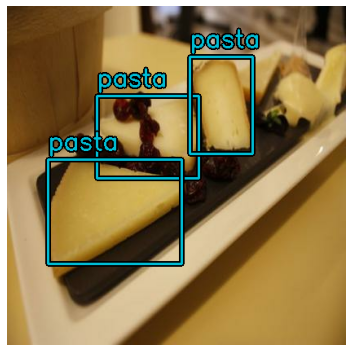

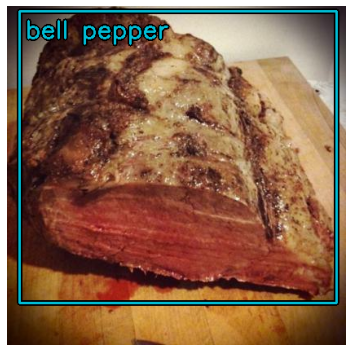

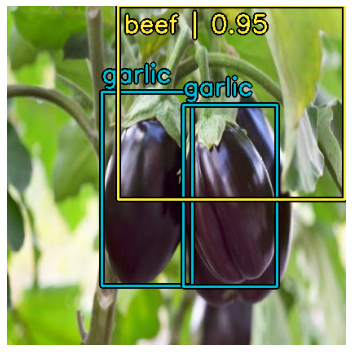

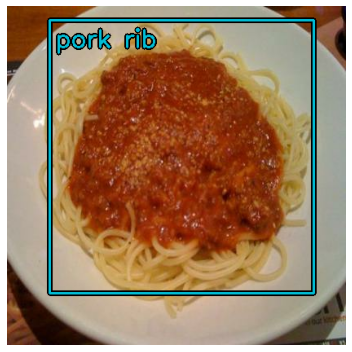

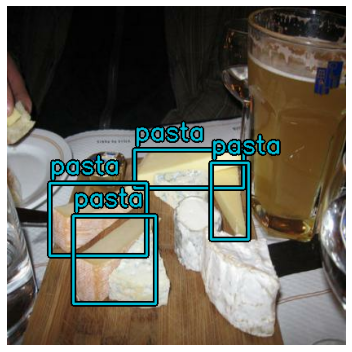

In [ ]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    from_logits=False,
    confidence_threshold=0.9,
    iou_threshold=0.1,
    bounding_box_format="xyxy",
)
for result in test_data.take(5):
    y_pred = model.predict(result[0])
    print(y_pred)
    visualization.plot_bounding_box_gallery(
        result[0],
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xyxy',
        y_pred=y_pred,
        y_true=result[1],
        class_mapping=class_mapping
    )

In [ ]:
model.export("/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model")

INFO:tensorflow:Assets written to: /mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model/assets


INFO:tensorflow:Assets written to: /mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model/assets


Saved artifact at '/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor_244')
Output Type:
  Dict[['boxes', TensorSpec(shape=(None, None, 64), dtype=tf.float32, name=None)], ['classes', TensorSpec(shape=(None, None, 38), dtype=tf.float32, name=None)]]
Captures:
  140599923132368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140599923132016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140599923136944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140599923133952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140599923134832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140599923140992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140599923130960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140599923145040: TensorSpec(shape=(), dtype=tf.r

In [ ]:
loaded_model = tf.keras.models.load_model("/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
{'boxes': array([[[  -1.      ,   -1.      ,   -1.      ,   -1.      ],
        [  -1.      ,   -1.      ,   -1.      ,   -1.      ],
        [  -1.      ,   -1.      ,   -1.      ,   -1.      ],
        ...,
        [  -1.      ,   -1.      ,   -1.      ,   -1.      ],
        [  -1.      ,   -1.      ,   -1.      ,   -1.      ],
        [  -1.      ,   -1.      ,   -1.      ,   -1.      ]],

       [[  -1.      ,   -1.      ,   -1.      ,   -1.      ],
        [  -1.      ,   -1.      ,   -1.      ,   -1.      ],
        [  -1.      ,   -1.      ,   -1.      ,   -1.      ],
        ...,
        [  -1.      ,   -1.      ,   -1.      ,   -1.      ],
        [  -1.      ,   -1.      ,   -1.      ,   -1.      ],
        [  -1.      ,   -1.      ,   -1.      ,   -1.      ]],

       [[-356.34537 ,  372.9638  ,   57.126965,  782.704   ],
        [  -1.      ,   -1.      ,   -1.      ,   -1.      ],
        [  -1.      ,   -1.      ,   -1.      ,   -1.   

2024-06-09 10:42:08.391286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


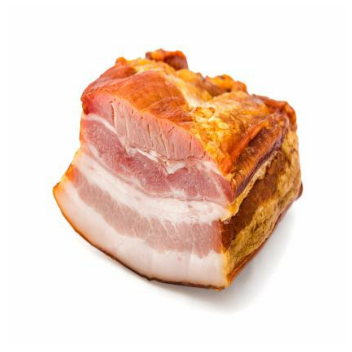

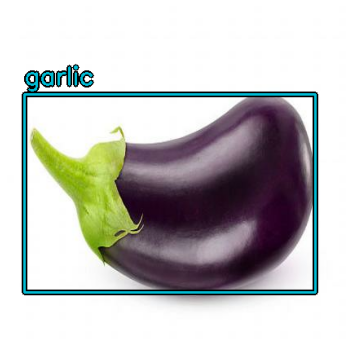

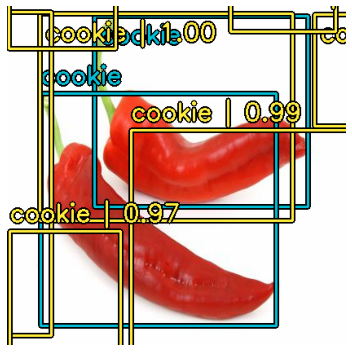

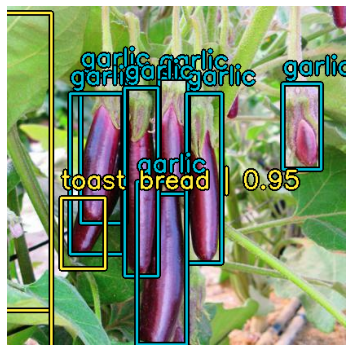

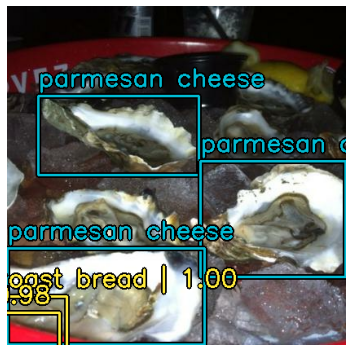

In [ ]:
loaded_model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    from_logits=False,
    confidence_threshold=0.95,
    iou_threshold=0.1,
    bounding_box_format="xyxy",
)
for result in test_data.take(5):
    y_pred = loaded_model.predict(result[0])
    print(y_pred)
    visualization.plot_bounding_box_gallery(
        result[0],
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xyxy',
        y_pred=y_pred,
        y_true=result[1],
        class_mapping=class_mapping
    )

In [ ]:
loaded_model.compile(
    optimizer=optimizer, 
    # classification_loss="binary_crossentropy", 
    classification_loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    box_loss=keras_cv.losses.CIoULoss("xyxy", eps=1e-07)
)

In [ ]:
loaded_model.evaluate(test_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 6.7972e-05


2024-06-09 10:36:04.413300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 10:36:04.413606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


6.602334906347096e-05

In [ ]:
loaded_model.export("/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model")

INFO:tensorflow:Assets written to: /mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model/assets


INFO:tensorflow:Assets written to: /mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model/assets


Saved artifact at '/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor_866')
Output Type:
  Dict[['boxes', TensorSpec(shape=(None, None, 64), dtype=tf.float32, name=None)], ['classes', TensorSpec(shape=(None, None, 38), dtype=tf.float32, name=None)]]
Captures:
  140596095100960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140596306203872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140596306209504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140596306209152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140596306212144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140596306204048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140596306199824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140596306200352: TensorSpec(shape=(), dtype=tf.r

In [ ]:
print(model.outputs)

[<KerasTensor shape=(None, None, 64), dtype=float32, sparse=False, name=keras_tensor_431>, <KerasTensor shape=(None, None, 38), dtype=float32, sparse=False, name=keras_tensor_432>]
